### Preparing the notebook

####<b> Mounting the Drive

In [2]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####<b>Loading libraries</b>

In [3]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

#Required for evaluating the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [4]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/CNN Malaria Detection/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

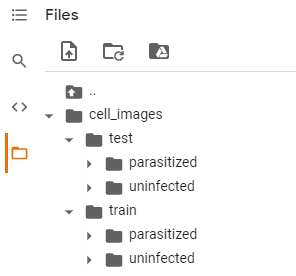

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [5]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [6]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (224,224)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [8]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (128,128)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

####<b>Normalize the images

In [9]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255).astype('float32')
test_images = (test_images/225).astype('float32')

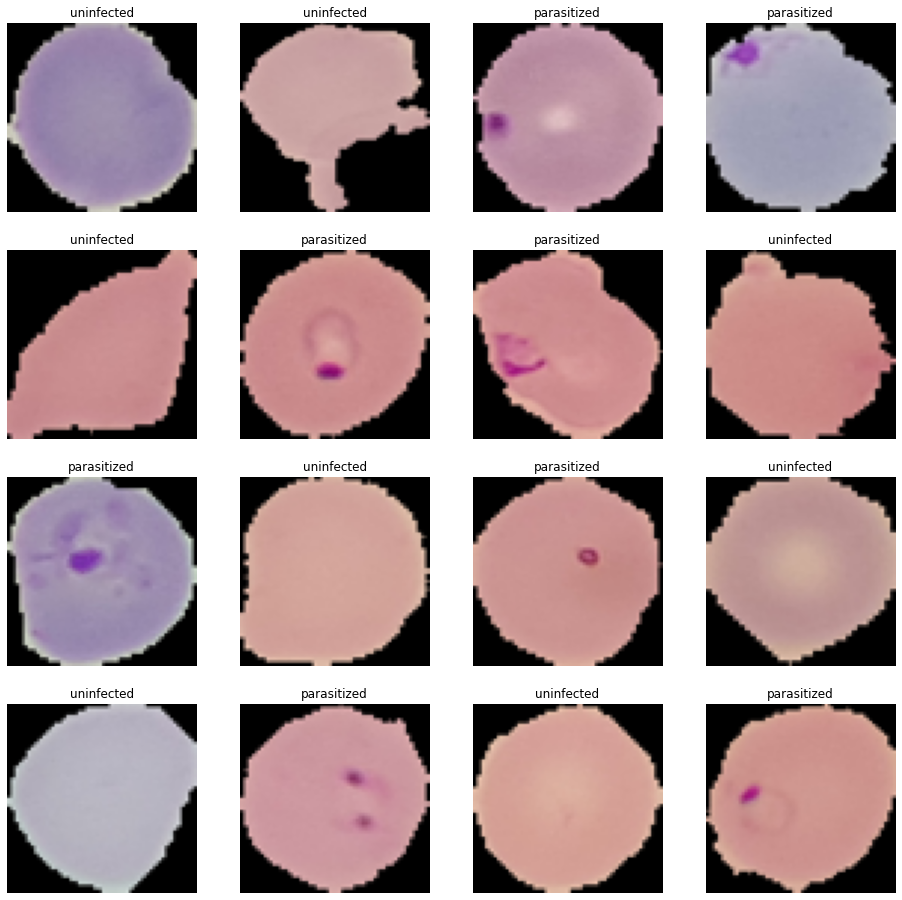

In [10]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

####<B>One Hot Encoding on the train and test labels

In [11]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

[1.0.] is uninfected, [0.1.] is paracitized


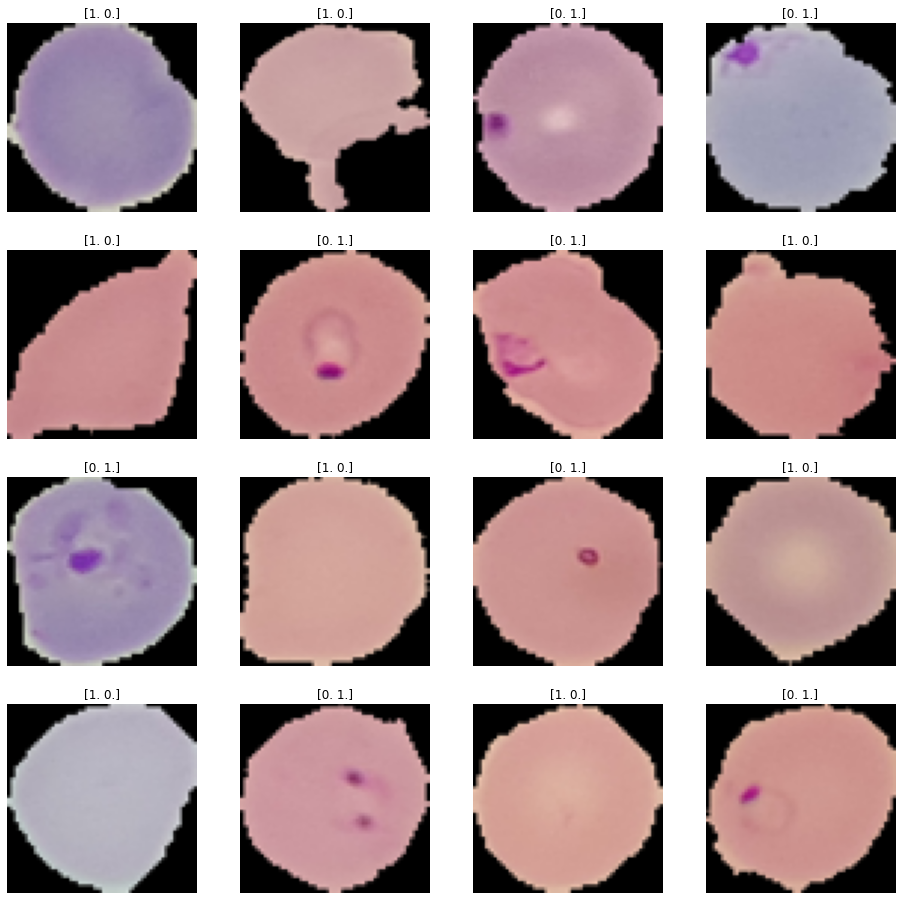

In [12]:
# This code will help you in visualizing both the parasitized and uninfected images
print('[1.0.] is uninfected, [0.1.] is paracitized')

np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    plt.title(train_labels[index] )
    plt.imshow(train_images[index])
    plt.axis('off')

####<b> Importing the required libraries

In [13]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [14]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

### Model 5 - final model base

#### Building the model

In [48]:
#creating sequential model
model5=Sequential()

# Original Model 

model5.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5.add(MaxPooling2D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Dropout(0.2))

#Increasing the number of filters to increase complexity

model5.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))

model5.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(Dropout(0.2)) #Dropout to reduce overfitting

model5.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(Dropout(0.2))

model5.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(LeakyReLU(0.1))


model5.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(BatchNormalization())

model5.add(Flatten())

model5.add(Dense(4096,activation="relu"))
model5.add(Dropout(0.4))
model5.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [49]:
# Compile the model
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [51]:
#Fit and train the model
history5 = model5.fit(train_images,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)

Epoch 1/20
312/312 [==============================] - 22s 66ms/step - loss: 0.5126 - accuracy: 0.7240 - val_loss: 0.5153 - val_accuracy: 0.9335
Epoch 2/20
312/312 [==============================] - 19s 62ms/step - loss: 0.1617 - accuracy: 0.9506 - val_loss: 0.2504 - val_accuracy: 0.9293
Epoch 3/20
312/312 [==============================] - 19s 62ms/step - loss: 0.1503 - accuracy: 0.9535 - val_loss: 0.1057 - val_accuracy: 0.9657
Epoch 4/20
312/312 [==============================] - 19s 62ms/step - loss: 0.1476 - accuracy: 0.9552 - val_loss: 0.1363 - val_accuracy: 0.9736
Epoch 5/20
312/312 [==============================] - 19s 62ms/step - loss: 0.1440 - accuracy: 0.9533 - val_loss: 0.1283 - val_accuracy: 0.9657


#### Evaluation of model 5 

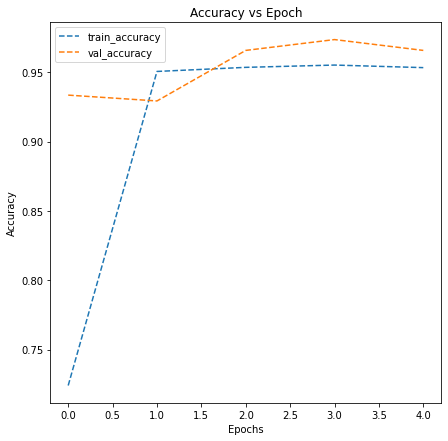

In [52]:
plot_accuracy(history5)

In [53]:
# Evaluating the model on test data
accuracy5 = model5.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy5[1])



82/82 [==============================] - 2s 13ms/step - loss: 0.1503 - accuracy: 0.9542

 Test_Accuracy:- 0.954230785369873


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1300
           1       0.96      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



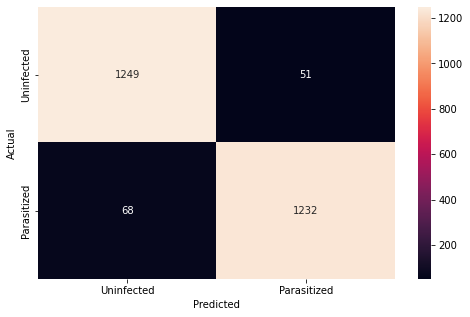

In [54]:
# Plot the confusion matrix and generate a classification report for the model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model5.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Notes

- Model 5 has the highest reported accuracy so far
- Data augmentation has ntoo increased the accuracy
- The model does not appear to over fit the data
    - drop out and generalization layers will not increase accuracy
- Next steps
    - Add more convoution layers 
    - 

### Model 5.1 - more convlution layers 

####Building the model

In [55]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [56]:
#creating sequential model
model5_1=Sequential()

# Original Model 

model5_1.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model5_1.add(MaxPooling2D(pool_size=2))
model5_1.add(Dropout(0.2))
model5_1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_1.add(MaxPooling2D(pool_size=2))
model5_1.add(Dropout(0.2))
model5_1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model5_1.add(MaxPooling2D(pool_size=2))
model5_1.add(Dropout(0.2))
model5_1.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))
model5_1.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))
model5_1.add(Dropout(0.2)) #Dropout to reduce overfitting
model5_1.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))
model5_1.add(Dropout(0.2))

#newly added layers
model5_1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))

model5_1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))

model5_1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))

model5_1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))

#end of new layers

model5_1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))
model5_1.add(LeakyReLU(0.1))
model5_1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_1.add(MaxPooling2D(pool_size=2,padding='same'))
model5_1.add(BatchNormalization())
model5_1.add(Flatten())
model5_1.add(Dense(4096,activation="relu"))
model5_1.add(Dropout(0.4))
model5_1.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model5_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [57]:
# Compile the model
model5_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [59]:
#Fit and train the model
history5_1 = model5_1.fit(train_images,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)

Epoch 1/20
312/312 [==============================] - 23s 68ms/step - loss: 0.4605 - accuracy: 0.7611 - val_loss: 0.3263 - val_accuracy: 0.9681
Epoch 2/20
312/312 [==============================] - 22s 70ms/step - loss: 0.1543 - accuracy: 0.9512 - val_loss: 0.2163 - val_accuracy: 0.9529
Epoch 3/20
312/312 [==============================] - 22s 70ms/step - loss: 0.1515 - accuracy: 0.9526 - val_loss: 0.1656 - val_accuracy: 0.9527
Epoch 4/20
312/312 [==============================] - 23s 73ms/step - loss: 0.1456 - accuracy: 0.9534 - val_loss: 0.2032 - val_accuracy: 0.9585
Epoch 5/20
312/312 [==============================] - 22s 69ms/step - loss: 0.1442 - accuracy: 0.9537 - val_loss: 0.2061 - val_accuracy: 0.9621


#### Evaluate the model

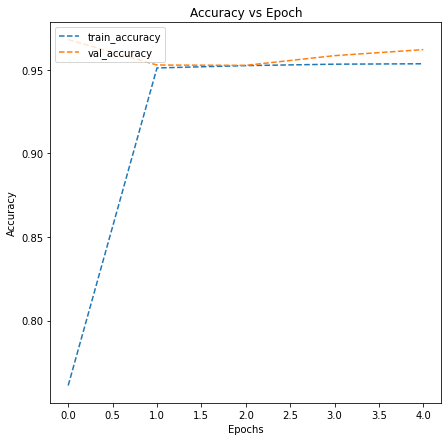

In [60]:
plot_accuracy(history5_1)

In [61]:
# Evaluating the model on test data
accuracy5_1 = model5_1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy5_1[1])

82/82 [==============================] - 1s 12ms/step - loss: 0.1767 - accuracy: 0.9500

 Test_Accuracy:- 0.949999988079071


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



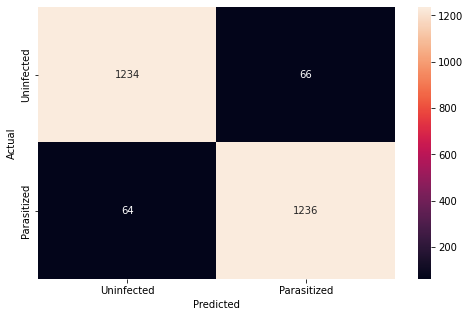

In [62]:
pred = model5_1.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Notes

Model 5.1 has decreased accuracy (95.19 vs 95.23) but has also decreeased the number of false positives (62 vs 65) there is not enought evidence to use this model. 

Further testing 
- increase the filter size (5.2)  
- increase the number of convolution layers (5.3) 

### Model 5.2

####Building the model

In [63]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [64]:
#creating sequential model
model5_2=Sequential()

# Original Model 

model5_2.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model5_2.add(MaxPooling2D(pool_size=2))
model5_2.add(Dropout(0.2))
model5_2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_2.add(MaxPooling2D(pool_size=2))
model5_2.add(Dropout(0.2))
model5_2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model5_2.add(MaxPooling2D(pool_size=2))
model5_2.add(Dropout(0.2))
model5_2.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Dropout(0.2)) #Dropout to reduce overfitting
model5_2.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Dropout(0.2))

#newly added layers attempt 1
model5_2.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))

'''
#attempt 2
model5_2.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))

model5_2.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))

model5_2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))

model5_2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))

#attempt 3
model5_2.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))'

model5_2.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))

model5_2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))

model5_2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))            
#model5_2.add(MaxPooling2D(pool_size=2,padding='same'))'''

#end of new layers

model5_2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(LeakyReLU(0.1))
model5_2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_2.add(MaxPooling2D(pool_size=2,padding='same'))
model5_2.add(BatchNormalization())
model5_2.add(Flatten())
model5_2.add(Dense(4096,activation="relu"))
model5_2.add(Dropout(0.2)) #droup out changes to .2
model5_2.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model5_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [65]:
# Compile the model
model5_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [67]:
#Fit and train the model
history5_2 = model5_2.fit(train_images,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)

Epoch 1/20
312/312 [==============================] - 23s 67ms/step - loss: 0.5157 - accuracy: 0.7285 - val_loss: 0.4475 - val_accuracy: 0.9205
Epoch 2/20
312/312 [==============================] - 20s 65ms/step - loss: 0.1579 - accuracy: 0.9497 - val_loss: 0.2839 - val_accuracy: 0.9377
Epoch 3/20
312/312 [==============================] - 21s 66ms/step - loss: 0.1536 - accuracy: 0.9520 - val_loss: 0.1207 - val_accuracy: 0.9706
Epoch 4/20
312/312 [==============================] - 21s 68ms/step - loss: 0.1474 - accuracy: 0.9542 - val_loss: 0.2258 - val_accuracy: 0.9619
Epoch 5/20
312/312 [==============================] - 21s 67ms/step - loss: 0.1452 - accuracy: 0.9520 - val_loss: 0.1640 - val_accuracy: 0.9617


#### Evaluate the model

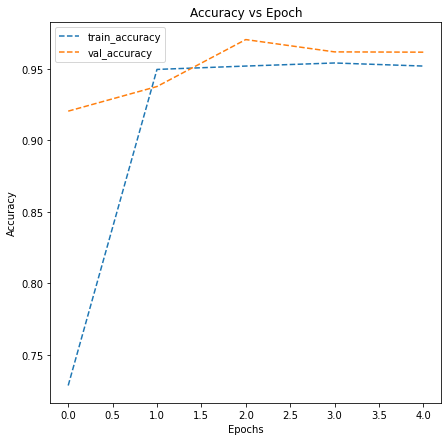

In [68]:
plot_accuracy(history5_2)

In [69]:
# Evaluating the model on test data
accuracy5_2 = model5_2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy5_2[1])

82/82 [==============================] - 1s 12ms/step - loss: 0.1592 - accuracy: 0.9538

 Test_Accuracy:- 0.9538461565971375


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



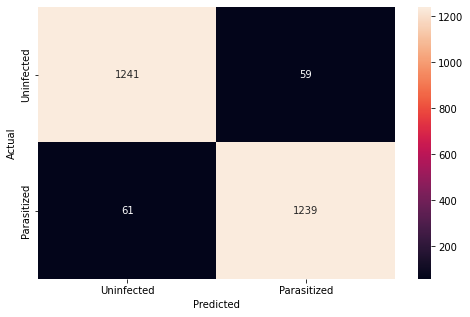

In [70]:
pred = model5_2.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Notes

- Increased accuracy and decreased false positive with 4 added layers (95.4 and 44)
- Decreased accuracy and decreased false positive with 8 added layers (95.15 and 42)
- Decreased accuracy with 16 added layers increased false positive. 

Increasing the layers marginally increased the accuracyup to a point. 


### Model 5.3 - Changing random features

- attempt 1: change all relu to leaky relu - 93.9 and 79
- attempt 2: reorganize layers from largest to smallest 95.46 and 53
- attempt 3: reorganize layers from smallest to largest (95.00, 71)

####Building the model

In [71]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [72]:
#creating sequential model
model5_3=Sequential()

#model 5.2 as base
model5_3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu", input_shape=(64,64,3)))            
model5_3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_3.add(MaxPooling2D(pool_size=2,padding='same'))
model5_3.add(LeakyReLU(0.1))
model5_3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_3.add(MaxPooling2D(pool_size=2,padding='same'))

model5_3.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_3.add(MaxPooling2D(pool_size=2))
model5_3.add(Dropout(0.2))
model5_3.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model5_3.add(MaxPooling2D(pool_size=2))
model5_3.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))

model5_3.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5_3.add(MaxPooling2D(pool_size=2))
model5_3.add(Dropout(0.2))
model5_3.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5_3.add(MaxPooling2D(pool_size=2,padding='same'))
model5_3.add(Dropout(0.2))
model5_3.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))

model5_3.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_3.add(MaxPooling2D(pool_size=2,padding='same'))
model5_3.add(Dropout(0.2)) 
model5_3.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_3.add(MaxPooling2D(pool_size=2,padding='same'))
model5_3.add(Dropout(0.2)) 
model5_3.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))

model5_3.add(BatchNormalization())
model5_3.add(Flatten())
model5_3.add(Dense(4096,activation="relu"))
model5_3.add(Dropout(0.4))
model5_3.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model5_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        8

In [73]:
# Compile the model
model5_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [75]:
#Fit and train the model
history5_3 = model5_3.fit(train_images,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)

Epoch 1/20
312/312 [==============================] - 17s 48ms/step - loss: 0.2612 - accuracy: 0.8898 - val_loss: 0.5537 - val_accuracy: 0.9409
Epoch 2/20
312/312 [==============================] - 14s 44ms/step - loss: 0.1548 - accuracy: 0.9517 - val_loss: 0.4154 - val_accuracy: 0.8984
Epoch 3/20
312/312 [==============================] - 14s 43ms/step - loss: 0.1516 - accuracy: 0.9524 - val_loss: 0.1821 - val_accuracy: 0.9613
Epoch 4/20
312/312 [==============================] - 14s 45ms/step - loss: 0.1498 - accuracy: 0.9526 - val_loss: 0.1299 - val_accuracy: 0.9716
Epoch 5/20
312/312 [==============================] - 14s 45ms/step - loss: 0.1409 - accuracy: 0.9540 - val_loss: 0.1913 - val_accuracy: 0.9565
Epoch 6/20
312/312 [==============================] - 14s 43ms/step - loss: 0.1378 - accuracy: 0.9554 - val_loss: 0.1879 - val_accuracy: 0.9681


#### Evaluate the model

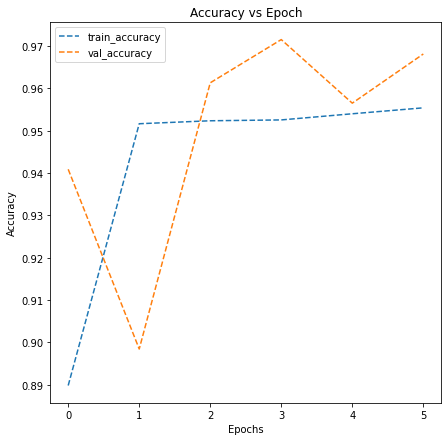

In [76]:
plot_accuracy(history5_3)

In [77]:
# Evaluating the model on test data
accuracy5_3 = model5_3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy5_3[1])

82/82 [==============================] - 1s 12ms/step - loss: 0.1646 - accuracy: 0.9512

 Test_Accuracy:- 0.9511538743972778


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1300
           1       0.96      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



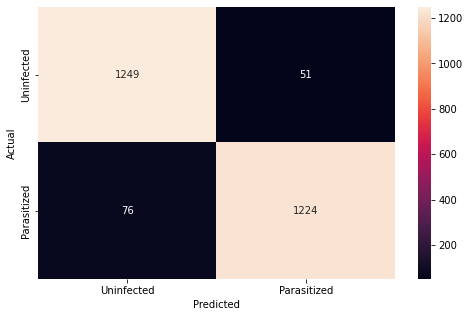

In [78]:
pred = model5_3.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Notes

- Organizing the model form largest filter to smallest increases the accuracy marganally. 

- futher attempts:
    - make a wider net (512 filters) 

###Model 5.4 - one last attempt with a deeper model

- attempt 1: layer of 512 filters, 94.61, 89.  
- attempt 2: Added layer with 1024 filters, 94.77, 65


Adding depth and width has decreased the accuracy and increased the number of false negatives. 

#### Building the Model

In [15]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [16]:
#creating sequential model
model5_4=Sequential()

model5_4.add(Conv2D(filters=512,kernel_size=2,padding="same",activation="relu", input_shape=(64,64,3)))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(Dropout(0.2)) 
model5_4.add(Conv2D(filters=1024,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(Dropout(0.2)) 
model5_4.add(Conv2D(filters=1024,kernel_size=2,padding="same",activation="relu"))

model5_4.add(Conv2D(filters=512,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(Dropout(0.2)) 
model5_4.add(Conv2D(filters=512,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(Dropout(0.2)) 
model5_4.add(Conv2D(filters=512,kernel_size=2,padding="same",activation="relu"))

model5_4.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(Dropout(0.2)) 
model5_4.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(Dropout(0.2)) 
model5_4.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))

model5_4.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2, padding='same'))
model5_4.add(Dropout(0.2))
model5_4.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(Dropout(0.2))
model5_4.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))

model5_4.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5_4.add(MaxPooling2D(pool_size=2, padding='same'))
model5_4.add(Dropout(0.2))
model5_4.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2, padding='same'))
model5_4.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))

model5_4.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))            
model5_4.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))
model5_4.add(LeakyReLU(0.1))
model5_4.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5_4.add(MaxPooling2D(pool_size=2,padding='same'))

model5_4.add(BatchNormalization())
model5_4.add(Flatten())
model5_4.add(Dense(4096,activation="relu"))
model5_4.add(Dropout(0.4))
model5_4.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model5_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 512)       6656      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 1024)      2098176   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 1024)      4

In [17]:
# Compile the model
model5_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [ ]:
#Fit and train the model
history5_4 = model5_4.fit(train_images,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.1, verbose=1)


Epoch 1/20
312/312 [==============================] - 437s 1s/step - loss: 0.6630 - accuracy: 0.6249 - val_loss: 1.0107 - val_accuracy: 0.0000e+00
Epoch 2/20
312/312 [==============================] - 373s 1s/step - loss: 0.6620 - accuracy: 0.6250 - val_loss: 1.0464 - val_accuracy: 0.0000e+00
Epoch 3/20
312/312 [==============================] - 373s 1s/step - loss: 0.6629 - accuracy: 0.6241 - val_loss: 0.9902 - val_accuracy: 0.0000e+00
Epoch 4/20
 46/312 [===>..........................] - ETA: 4:51 - loss: 0.6579 - accuracy: 0.6328

#### Evaluate the model

In [ ]:
plot_accuracy(history5_4)

In [ ]:
# Evaluating the model on test data
accuracy5_4 = model5_4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy5_4[1])

In [ ]:
pred = model5_4.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()